In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from params import *
import tqdm
import ghibtools as gh
import seaborn as sns
import pingouin as pg
%matplotlib inline

## TOOLS

APPROCHE PHASE

In [3]:
def encoded_to_usable_df(save=False):
    for patient in patients:
        encoded = pd.read_excel(f'../df_analyse/resp_features_encoded_{patient}.xlsx', index_col = 0)
        spindled = encoded[encoded['spindling code'] == 1].reset_index(drop= True)
        end_cycles = []
        for cycle in range(spindled.shape[0]):
            end_resp = spindled.loc[cycle, 'inspi_time'] + spindled.loc[cycle, 'cycle_duration']
            end_cycles.append(end_resp)
        spindled['end_time'] = end_cycles
        spindled = spindled.drop(columns = ['inspi_index','expi_index','cycle_duration','insp_duration','exp_duration','cycle_freq','insp_volume','exp_volume','total_amplitude','insp_amplitude','exp_amplitude','spindling code'])
        if save:
            spindled.to_excel(f'../df_analyse/spindled_cycles_timings_{patient}.xlsx')

In [4]:
def load_rsp_spindles(patient, stage='N2'):
    spindle_file = f'../df_analyse/spindles_{patient}.xlsx'
    spindles = pd.read_excel(spindle_file).drop(columns = 'Unnamed: 0')
    spindles = spindles[spindles['stage'] == stage]
    spindles_times = spindles['Peak']

    df_cycles = pd.read_excel(f'../df_analyse/spindled_cycles_timings_{patient}.xlsx', index_col = 0)
    return df_cycles, spindles_times

In [5]:
def count_spindles_phase_resp_fast(nbins, patient, spindles_times, df_cycles, stage='N2', return_normal=True):

    count = []

    for cycle in df_cycles.index: # loop only on cycles with spindles found inside
        
        start = df_cycles.loc[cycle,'inspi_time'] # get start time of the cycle
        stop = df_cycles.loc[cycle,'end_time'] # get stop time of the cycle

        phases_timings = np.linspace(start, stop, nbins + 1) # slice the cycle time in n equal phase time points
        
        spindles_of_the_cycle = spindles_times[(spindles_times >= start) & (spindles_times <= stop)].values # keep the spindles of the cycle
        
        for spindle_time in spindles_of_the_cycle: # loop on spindles of the cycle
            for phase_bin, phase_start in enumerate(phases_timings): # loop on phases start times and attribute bin value to the phase
                if phase_start == phases_timings[-1]: # trick to stop looping if phase start == last phase timing
                    break 
                else:
                    phase_stop = phases_timings[phase_bin + 1] # stop time of this phase bin = next phase timing after the start phase timing of the list
                    if spindle_time >= phase_start and spindle_time < phase_stop: # if there is a spindle found between start and stop timings of the phase..
                        count.append(phase_bin) # ..the bin value is added to a counter

    if not return_normal: # return raw counts of spindles by bins
        phase_count = pd.Series(count).value_counts(normalize = False).reindex(np.arange(0,nbins))
        phase_count = phase_count.to_frame().T
    else: # return normalized counts of spindles by bins (each bin value = bin value / sum of all bin values) = default mode
        phase_count = pd.Series(count).value_counts(normalize = True).reindex(np.arange(0,nbins))
        phase_count = phase_count.to_frame().T
        mi = gh.Modulation_Index(phase_count.values)
        phase_count.insert(0 , 'mi', mi)

    phase_count.insert(0 , 'patient', patient)

    return phase_count

In [6]:
def get_patient_phase_histogram(patient, nbins, stage='N2'):
    df_cycles, spindles_times = load_rsp_spindles(patient, stage)
    count = count_spindles_phase_resp_fast(nbins=nbins, patient=patient, spindles_times=spindles_times, df_cycles=df_cycles, stage=stage)
    count.insert(1 , 'stage' , stage)
    return count

In [7]:
def get_all_patients_phase_histogram(nbins, patients, show=False):
    concat = []
    for patient in patients:
        # print(patient)
        concat.append(get_patient_phase_histogram(patient=patient, nbins=nbins))
    df = pd.concat(concat)

    if show: 
        for patient in patients:
            print(patient)
            gh.Modulation_Index(df.set_index('patient').drop(columns = ['stage','mi']).loc[patient,:].values, show = True)
            plt.show()
            
    return df

In [8]:
def to_tidy(df):
    patients = df['patient'].values
    df = df.set_index('patient')
    rows = []
    for patient in patients:
        stage = df.loc[patient,'stage']
        mi = df.loc[patient,'mi']
        phases = [col for col in df.columns if not col in ['stage','mi']]
        for phase in phases:
            phase_value = df.loc[patient,phase]
            rows.append([patient, stage, mi , phase, phase_value])
    return pd.DataFrame(rows, columns = ['patient','stage','mi','phase','bin value'])
            

## GO

In [9]:
df_2 = get_all_patients_phase_histogram(2, patients)

In [10]:
df_2

,patient,stage,mi,0,1
0,P1,N2,0.003053,0.467485,0.532515
0,P2,N2,0.013197,0.432473,0.567527
0,P3,N2,0.012368,0.434624,0.565376
0,P4,N2,0.000961,0.481752,0.518248
0,P5,N2,0.006456,0.452734,0.547266
0,P6,N2,0.000273,0.490272,0.509728
0,P7,N2,0.001007,0.481322,0.518678
0,P8,N2,0.000041,0.496250,0.503750
0,P9,N2,0.000673,0.484725,0.515275
0,P10,N2,0.005302,0.457158,0.542842


In [11]:
df_2 = to_tidy(df_2)

In [12]:
ttest = pg.ttest(x= df_2[df_2['phase']==1]['bin value'] , y=0.5)

In [13]:
ttest

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.460383,9,two-sided,0.001576,"[0.52, 0.55]",1.410497,27.991,0.976612


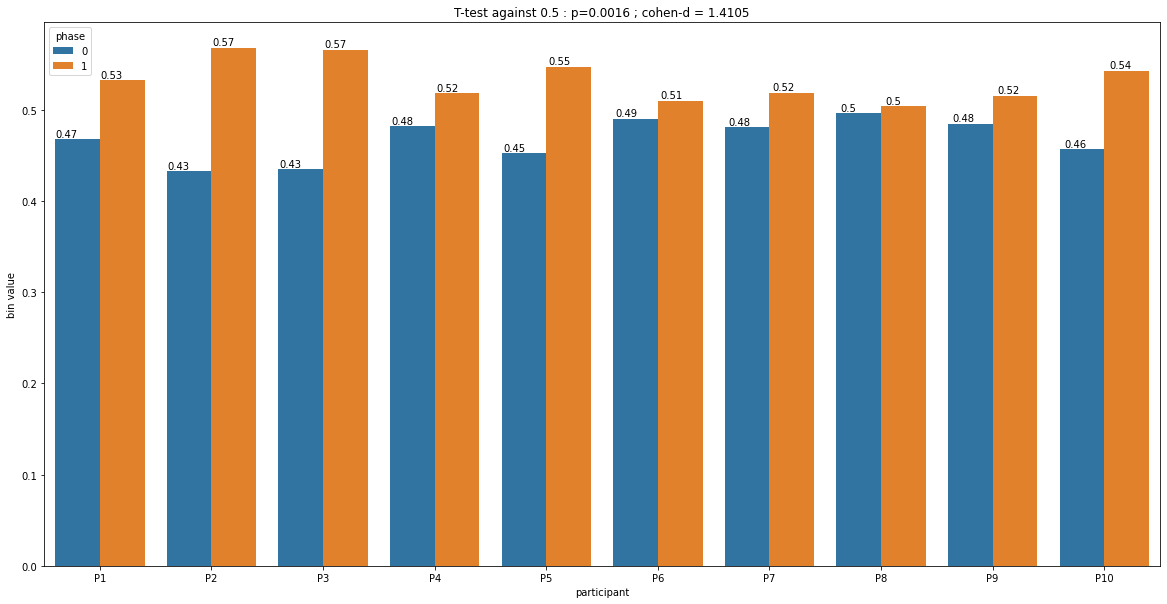

In [79]:
fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(data =df_2, x='patient', y ='bin value', hue = 'phase', ax=ax)
ax.set_xlabel('participant')
p = ttest.loc['T-test', 'p-val'].round(4)
cohen = ttest.loc['T-test', 'cohen-d'].round(4)
ax.set_title(f'T-test against 0.5 : p={p} ; cohen-d = {cohen}')
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))
# plt.savefig('../presentation_2/bar_2_bins')

In [15]:
df_18 = get_all_patients_phase_histogram(18, patients)
df_18

,patient,stage,mi,0,1,2,3,4,5,6,...,8,9,10,11,12,13,14,15,16,17
0,P1,N2,0.002354,0.058663,0.048204,0.059573,0.046839,0.055480,0.045475,0.053206,...,0.053206,0.055025,0.058663,0.059118,0.055935,0.055935,0.074579,0.059573,0.060482,0.053206
0,P2,N2,0.005643,0.048558,0.039833,0.048179,0.049317,0.053111,0.048938,0.049697,...,0.051214,0.073596,0.075493,0.059181,0.072838,0.053869,0.066388,0.055008,0.061836,0.049317
0,P3,N2,0.005904,0.054557,0.048766,0.034136,0.039012,0.045413,0.045108,0.054252,...,0.056690,0.053337,0.058824,0.074672,0.067358,0.068881,0.059433,0.060957,0.065529,0.056385
0,P4,N2,0.002306,0.052717,0.049878,0.056772,0.059205,0.058800,0.046634,0.058394,...,0.048256,0.050689,0.065288,0.068532,0.056772,0.062449,0.062449,0.051906,0.044607,0.055556
0,P5,N2,0.004595,0.034760,0.059771,0.053836,0.051717,0.056380,0.043663,0.043663,...,0.053412,0.053836,0.056380,0.065282,0.061891,0.062315,0.065706,0.075032,0.055108,0.051717
0,P6,N2,0.003744,0.052529,0.046693,0.046693,0.060311,0.065175,0.061284,0.062257,...,0.048638,0.059339,0.067121,0.050584,0.044747,0.056420,0.048638,0.063230,0.047665,0.071984
0,P7,N2,0.002056,0.054815,0.067956,0.058945,0.055378,0.054252,0.052938,0.047494,...,0.046931,0.053126,0.053876,0.055754,0.055378,0.055566,0.060822,0.056505,0.063826,0.063826
0,P8,N2,0.008726,0.061250,0.075000,0.053750,0.047500,0.041250,0.060000,0.077500,...,0.042500,0.055000,0.062500,0.080000,0.042500,0.063750,0.047500,0.061250,0.046250,0.045000
0,P9,N2,0.004217,0.061100,0.059063,0.041752,0.058045,0.059063,0.061100,0.052953,...,0.045825,0.058045,0.067210,0.075356,0.053971,0.046843,0.042770,0.052953,0.065173,0.052953
0,P10,N2,0.005346,0.060671,0.062267,0.057477,0.060138,0.048430,0.052155,0.035657,...,0.043108,0.050027,0.055349,0.060671,0.050027,0.063332,0.063864,0.067057,0.068121,0.064396


P1


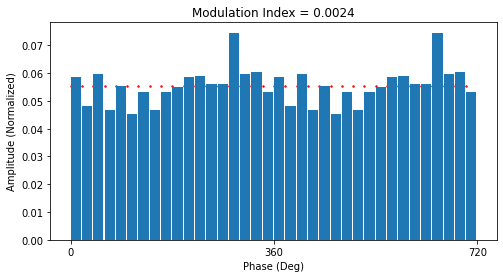

P2


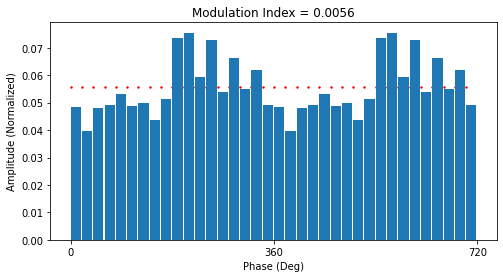

P3


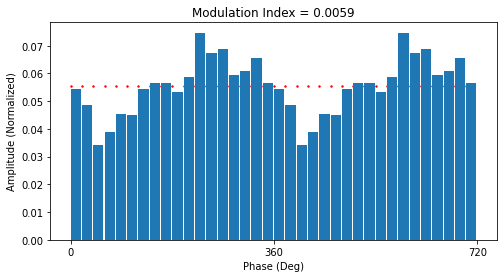

P4


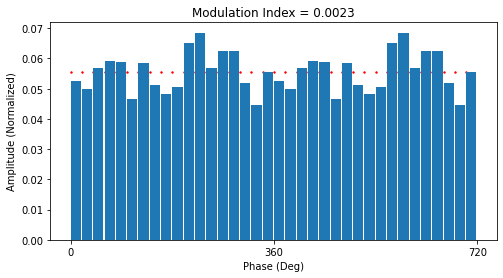

P5


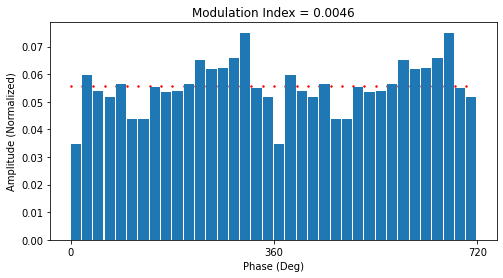

P6


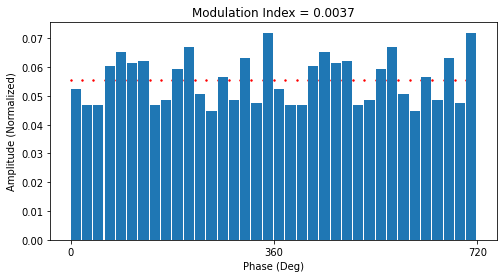

P7


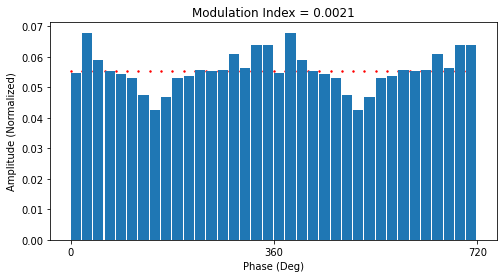

P8


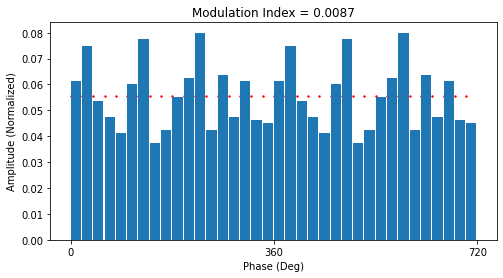

P9


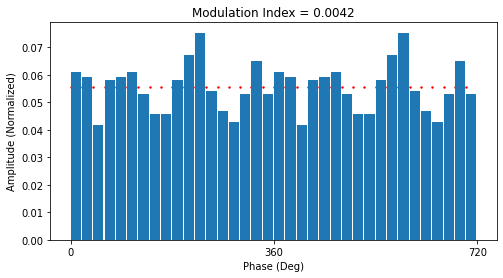

P10


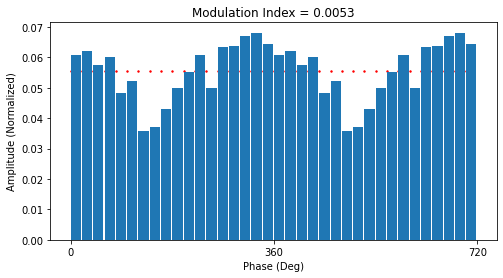

In [89]:
df_all = get_all_patients_phase_histogram(18, patients, show = True)

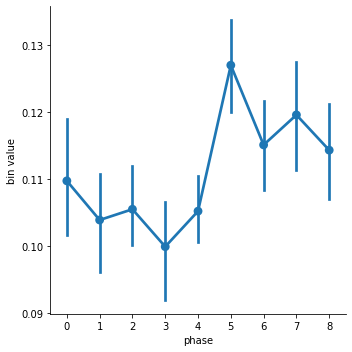

In [17]:
sns.catplot(data=to_tidy(df_all), x='phase', y = 'bin value', kind ='point')

APPROCHE TIME

In [18]:
df_cycles, spindles_times = load_rsp_spindles('P10')

In [19]:
df_cycles

,patient,inspi_time,expi_time,end_time
0,P10,3.253906,4.488281,6.738281
1,P10,6.738281,8.128906,10.234375
2,P10,13.597656,14.808594,17.046875
3,P10,17.046875,18.371094,20.539062
4,P10,20.539062,21.769531,23.792969
...,...,...,...,...
750,P10,7046.042969,7047.179688,7049.292969
751,P10,7052.468750,7053.636719,7055.765625
752,P10,7055.765625,7057.019531,7058.937500
753,P10,7058.937500,7060.156250,7062.218750


In [20]:
spindles_times

180        4.722656
181       23.281250
182       33.980469
183       51.832031
184      118.375000
           ...     
2847    7450.089844
2848    7509.449219
2849    8001.460938
2850    8584.339844
2851    8902.996094
Name: Peak, Length: 2672, dtype: float64

In [21]:
def get_timestamps(df_cycles, spindles_times, patient):
    rows = []

    for cycle in df_cycles.index: # loop only on cycles with spindles found inside

        start = df_cycles.loc[cycle,'inspi_time'] # get start time of the cycle
        transition = df_cycles.loc[cycle,'expi_time'] # get i-e time of the cycle
        stop = df_cycles.loc[cycle,'end_time'] # get stop time of the cycle
        duration = stop - start
        inspi_duration = transition - start
        expi_duration = stop - transition

        spindles_of_the_cycle = spindles_times[(spindles_times >= start) & (spindles_times <= stop)].values # keep the spindles of the cycle

        for spindle_time in spindles_of_the_cycle: # loop on spindles of the cycle
            time_post_start = spindle_time - start
            time_vs_transition = spindle_time - transition
            time_pre_end = stop - spindle_time

            norm_time = (spindle_time - start) / duration

            rows.append([patient, cycle, start, transition, stop, inspi_duration, expi_duration, duration, spindle_time, time_post_start, time_vs_transition, time_pre_end, norm_time])
    df_times = pd.DataFrame(rows, columns = ['patient','cycle','start cycle', 'transition ie', 'stop cycle', 'inspi duration','expi duration','cycle duration','spindle time', 'time post start', 'time vs transition ie','time pre end','norm time'])
    return df_times

In [22]:
concat_df_times = []

for patient in patients:
    df_cycles, spindles_times = load_rsp_spindles(patient)
    concat_df_times.append(get_timestamps(df_cycles, spindles_times, patient))
    
df_times_all = pd.concat(concat_df_times)

In [23]:
df_cycles

,patient,inspi_time,expi_time,end_time
0,P10,3.253906,4.488281,6.738281
1,P10,6.738281,8.128906,10.234375
2,P10,13.597656,14.808594,17.046875
3,P10,17.046875,18.371094,20.539062
4,P10,20.539062,21.769531,23.792969
...,...,...,...,...
750,P10,7046.042969,7047.179688,7049.292969
751,P10,7052.468750,7053.636719,7055.765625
752,P10,7055.765625,7057.019531,7058.937500
753,P10,7058.937500,7060.156250,7062.218750


In [24]:
spindles_times

180        4.722656
181       23.281250
182       33.980469
183       51.832031
184      118.375000
           ...     
2847    7450.089844
2848    7509.449219
2849    8001.460938
2850    8584.339844
2851    8902.996094
Name: Peak, Length: 2672, dtype: float64

In [25]:
df_times_all

,patient,cycle,start cycle,transition ie,stop cycle,inspi duration,expi duration,cycle duration,spindle time,time post start,time vs transition ie,time pre end,norm time
0,P1,0,15.316406,16.406250,17.960938,1.089844,1.554688,2.644531,16.878906,1.562500,0.472656,1.082031,0.590842
1,P1,0,15.316406,16.406250,17.960938,1.089844,1.554688,2.644531,16.507812,1.191406,0.101562,1.453125,0.450517
2,P1,1,27.113281,28.269531,30.230469,1.156250,1.960938,3.117188,29.421875,2.308594,1.152344,0.808594,0.740602
3,P1,2,30.230469,31.289062,33.234375,1.058594,1.945312,3.003906,32.152344,1.921875,0.863281,1.082031,0.639792
4,P1,2,30.230469,31.289062,33.234375,1.058594,1.945312,3.003906,32.066406,1.835938,0.777344,1.167969,0.611183
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1877,P10,753,7058.937500,7060.156250,7062.218750,1.218750,2.062500,3.281250,7062.191406,3.253906,2.035156,0.027344,0.991667
1878,P10,753,7058.937500,7060.156250,7062.218750,1.218750,2.062500,3.281250,7062.187500,3.250000,2.031250,0.031250,0.990476
1879,P10,753,7058.937500,7060.156250,7062.218750,1.218750,2.062500,3.281250,7062.187500,3.250000,2.031250,0.031250,0.990476
1880,P10,754,7072.054688,7073.234375,7075.253906,1.179688,2.019531,3.199219,7072.378906,0.324219,-0.855469,2.875000,0.101343


In [105]:
df_18.set_index('patient').loc['P1','mi'].round(3)

0.002

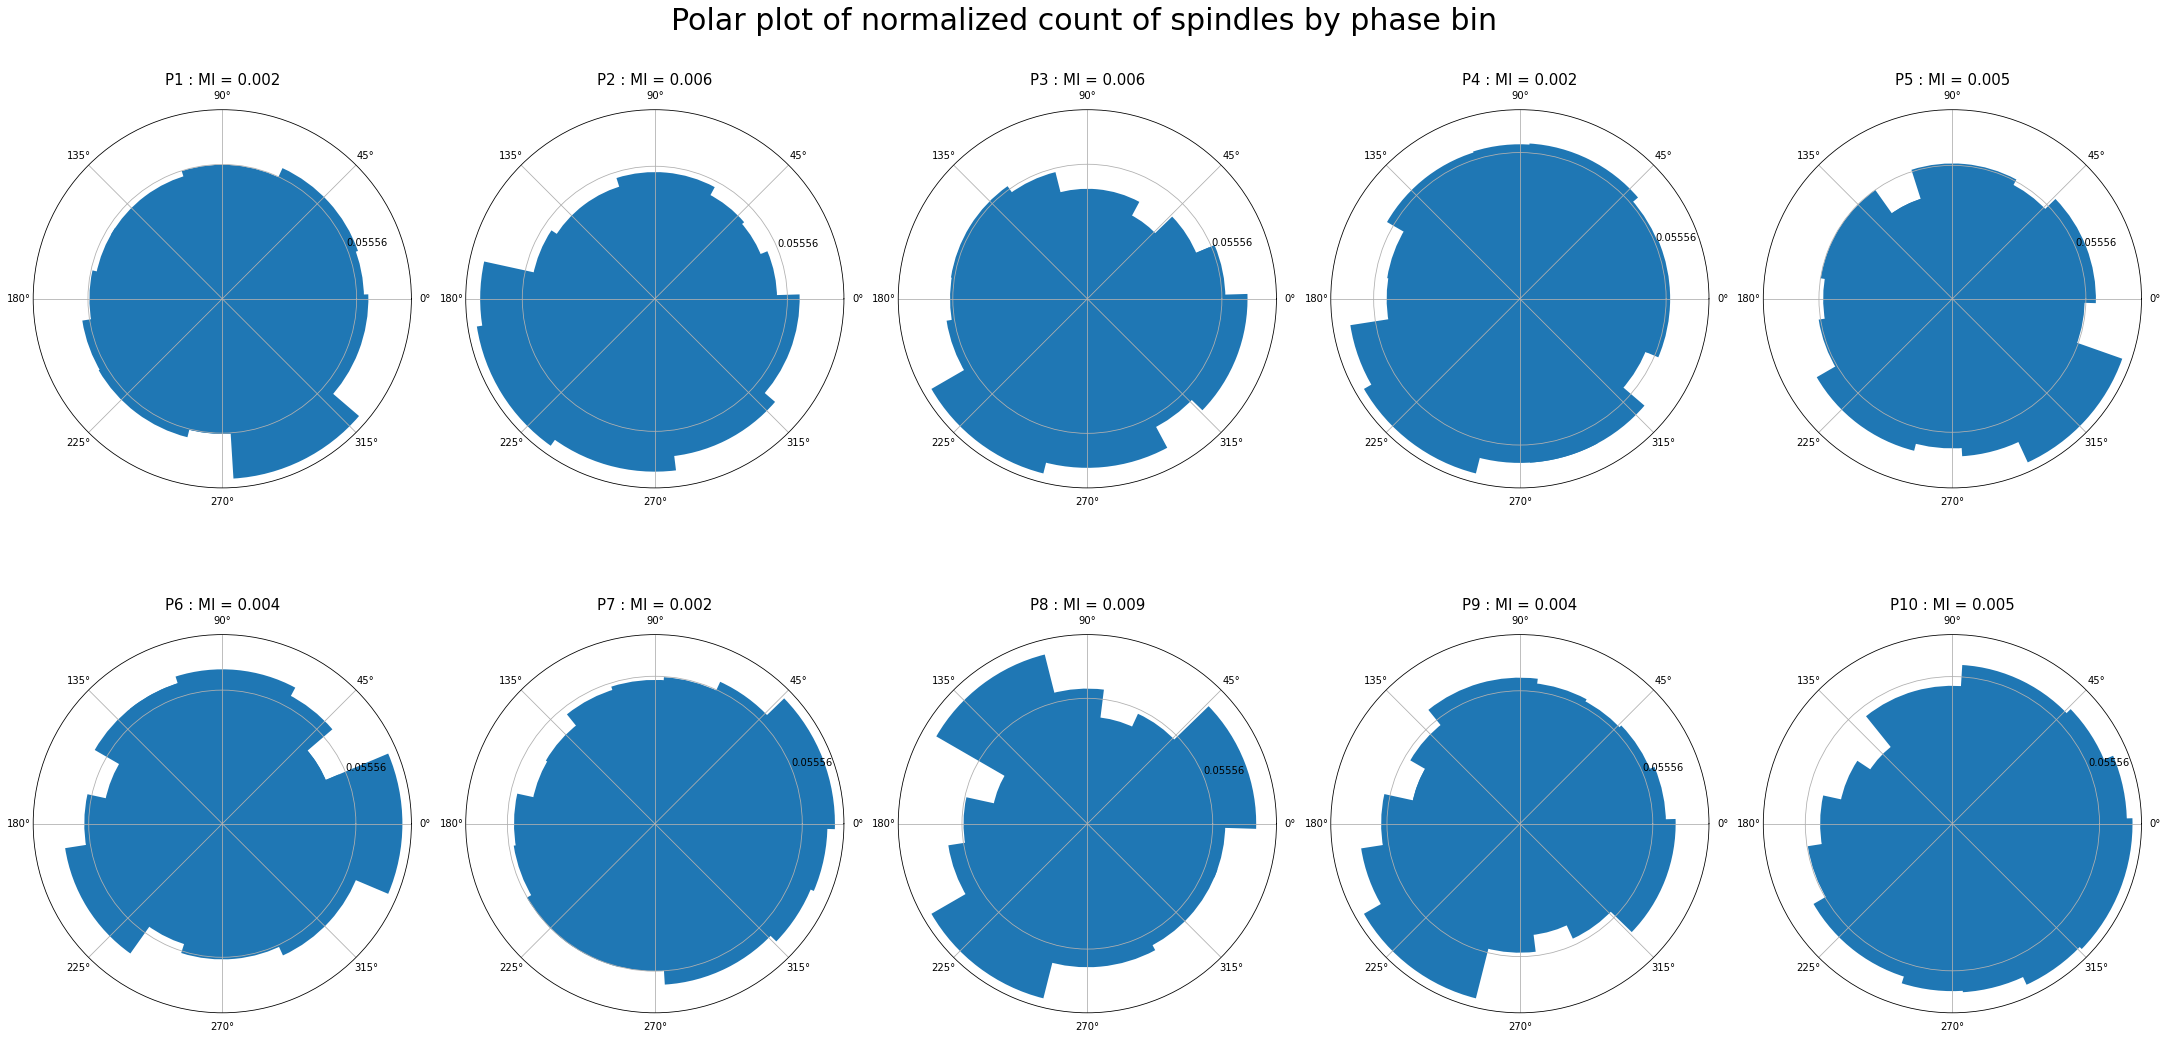

In [123]:
fig, axs = plt.subplots(nrows = 2, ncols = 5, subplot_kw=dict(projection = 'polar'), figsize = (30,15), constrained_layout = True)
fig.suptitle('Polar plot of normalized count of spindles by phase bin', fontsize = 30)
bins = 18
for row, sublist in enumerate([ patients[:5], patients[5:]]):
    for col, patient in enumerate(sublist):
        ax = axs[row, col]
        hist , values = np.histogram(df_times_all[df_times_all['patient'] == patient]['norm time'], bins = bins, density = True)
        ax.bar(np.linspace(0,2*np.pi,bins), hist / sum(hist))
        ax.set_rticks([1/bins])
        mi = df_18.set_index('patient').loc[patient,'mi'].round(3)
        ax.set_title(f'{patient} : MI = {mi}', fontsize = 15, y = 1.05)
# plt.savefig('../presentation_4/detailed_polar_plot')

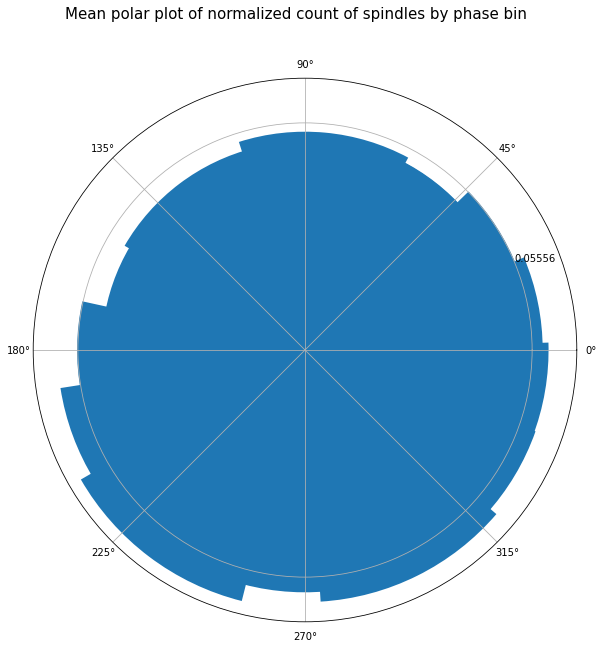

In [122]:
fig, ax = plt.subplots(subplot_kw=dict(projection = 'polar'), figsize = (10,10))
fig.suptitle('Mean polar plot of normalized count of spindles by phase bin', fontsize = 15)
bins = 18
hist , values = np.histogram(df_times_all['norm time'], bins = bins, density = False)
ax.bar(np.linspace(0,2*np.pi,bins), hist / sum(hist))
# ax.set_rmax(0.08)
ax.set_rticks([1/bins])
# plt.savefig('../presentation_4/mean_polar_plot')

<AxesSubplot:ylabel='Frequency'>

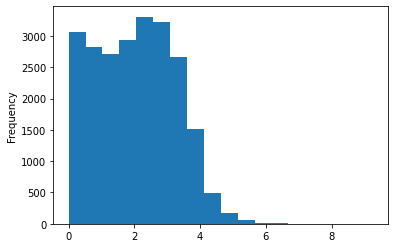

In [28]:
df_times_all['time post start'].plot.hist(bins = 18)

<AxesSubplot:ylabel='Frequency'>

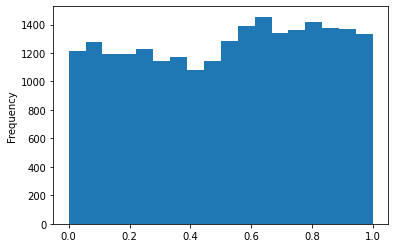

In [29]:
df_times_all['norm time'].plot.hist(bins=18)

<AxesSubplot:ylabel='Frequency'>

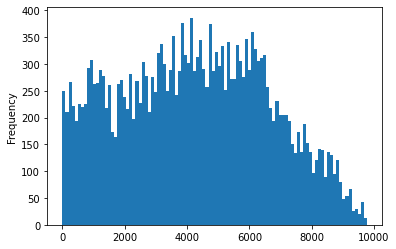

In [30]:
df_times_all['spindle time'].plot.hist(bins = 100)

<AxesSubplot:ylabel='Frequency'>

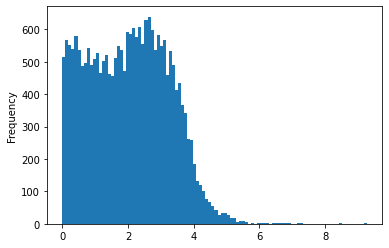

In [31]:
df_times_all['time post start'].plot.hist(bins = 100)

<AxesSubplot:ylabel='Frequency'>

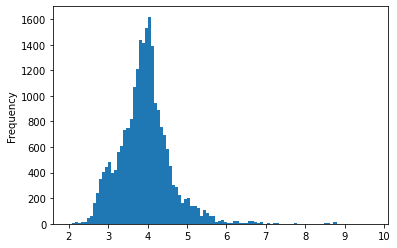

In [32]:
df_times_all['cycle duration'].plot.hist(bins = 100)

<AxesSubplot:ylabel='Frequency'>

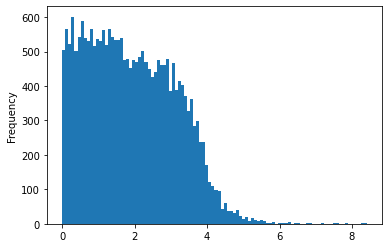

In [33]:
df_times_all['time pre end'].plot.hist(bins = 100)

In [50]:
def get_event_plot_patient(df, patient, ax=None, colname = 'norm time'):
    df_patient =  df[(df['patient'] == patient)][['cycle',colname,'cycle duration']].sort_values(by = 'cycle duration')
    rows = []
    for c in df_patient['cycle'].unique():
        row = df_patient[df_patient['cycle'] == c]
        rows.append(list(row[colname].values) )
        
    if ax is None:
        fig, ax = plt.subplots()
    ax.eventplot(rows,linelengths=10, linewidth = 2, colors = 'black')
    return ax

In [51]:
def lists_to_np_zero_padded(my_list):
    a_list = my_list

    row_lengths = []

    for row in a_list:
        row_lengths.append(len(row))

    max_length = max(row_lengths)

    for row in a_list:
        while len(row) < max_length:
            row.append(0)

    balanced_array = np.array(a_list)
    return balanced_array

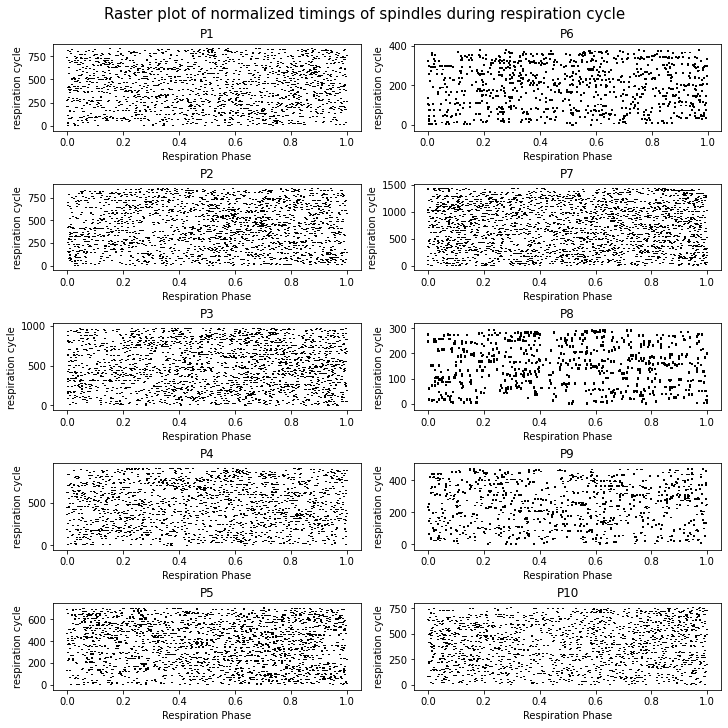

In [88]:
fig, axs = plt.subplots(ncols = 2, nrows = 5, figsize = (10,10), constrained_layout = True)
fig.suptitle('Raster plot of normalized timings of spindles during respiration cycle', fontsize = 15)
for col, semi_list in enumerate([patients[:5],patients[5:]]):
    for row, patient in enumerate(semi_list):
        ax = axs[row, col]
        ax = get_event_plot_patient(df=df_times_all, patient=patient, ax=ax, colname = 'norm time')
        ax.set_title(patient)
        ax.set_ylabel('respiration cycle')
        ax.set_xlabel('Respiration Phase')
# plt.savefig('../presentation_4/raster_plot_normalized')
plt.show()

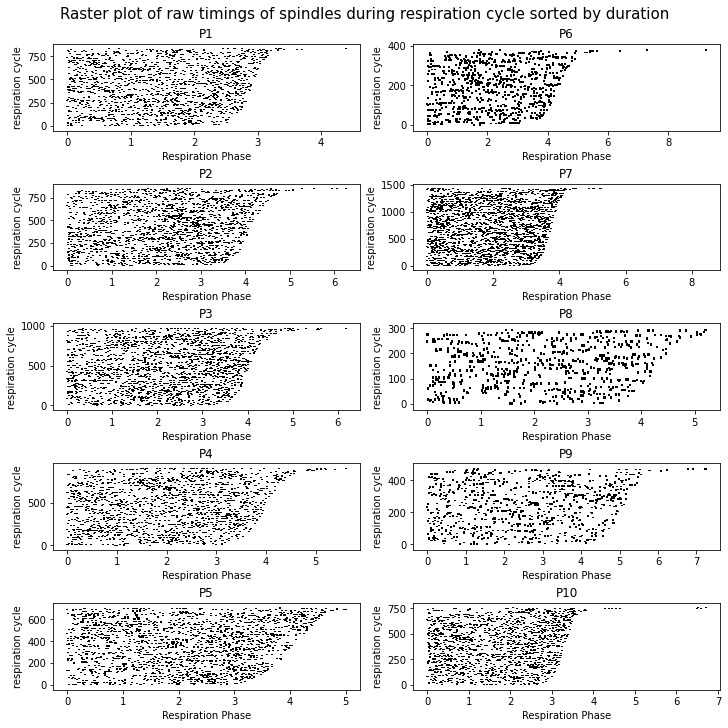

In [86]:
fig, axs = plt.subplots(ncols = 2, nrows = 5, figsize = (10,10), constrained_layout = True)
fig.suptitle('Raster plot of raw timings of spindles during respiration cycle sorted by duration', fontsize = 15)
for col, semi_list in enumerate([patients[:5],patients[5:]]):
    for row, patient in enumerate(semi_list):
        ax = axs[row, col]
        ax = get_event_plot_patient(df=df_times_all, patient=patient, ax=ax, colname = 'time post start')
        ax.set_title(patient)
        ax.set_ylabel('respiration cycle')
        ax.set_xlabel('Respiration Phase')
# plt.savefig('../presentation_4/raster_plot_sorted')
plt.show()

In [57]:
def get_timestamps_décalé(df_cycles, spindles_times, patient):
    rows = []

    for cycle in df_cycles.index: # loop only on cycles with spindles found inside
        
        if cycle == df_cycles.index[-1]:
            break

        start = df_cycles.loc[cycle,'expi_time'] # get start time of the cycle
        transition = df_cycles.loc[cycle+1,'inspi_time'] # get i-e time of the cycle
        stop = df_cycles.loc[cycle+1,'expi_time'] # get stop time of the cycle
        duration = stop - start

        spindles_of_the_cycle = spindles_times[(spindles_times >= start) & (spindles_times <= stop)].values # keep the spindles of the cycle

        for spindle_time in spindles_of_the_cycle: # loop on spindles of the cycle
            time_post_start = spindle_time - start
            time_vs_transition = spindle_time - transition
            time_pre_end = stop - spindle_time

            norm_time = (spindle_time - start) / duration

            rows.append([patient, cycle, start, duration, spindle_time, time_post_start, time_vs_transition, time_pre_end, norm_time])
    df_times = pd.DataFrame(rows, columns = ['patient','cycle','start cycle', 'cycle duration','spindle time', 'time post start', 'time vs transition ei','time pre end','norm time'])
    return df_times

In [65]:
def spindle_speed(df):
    df_patient =  df[(df['patient'] == patient)]
    rows = []
    for c in df_patient['cycle'].unique():
        row = df_patient[df_patient['cycle'] == c]
        rows.append(row[colname].values)
        
    if ax is None:
        fig, ax = plt.subplots()
    ax.eventplot(rows,linelengths=10, linewidth = 2, colors = 'black')
    return ax

In [70]:
def speed_spindles(step, patient, spindles_times, df_cycles, stage='N2', return_normal=True):

    rows = []

    for cycle in df_cycles.index: # loop only on cycles with spindles found inside
        
        start = df_cycles.loc[cycle,'inspi_time'] # get start time of the cycle
        stop = df_cycles.loc[cycle,'end_time'] # get stop time of the cycle

        phases_timings = np.arange(start, stop, step) # slice the cycle time in n equal phase time points
        
        spindles_of_the_cycle = spindles_times[(spindles_times >= start) & (spindles_times <= stop)].values # keep the spindles of the cycle
        
        for phase_bin, phase_start in enumerate(phases_timings): # loop on phases start times and attribute bin value to the phase
            if phase_start == phases_timings[-1]: # trick to stop looping if phase start == last phase timing
                break 
            else:
                phase_stop = phases_timings[phase_bin + 1] # stop time of this phase bin = next phase timing after the start phase timing of the list
                nspindles_in_time_slice = spindles_times[(spindles_times >= phase_start) & (spindles_times <= phase_stop)].shape[0]
                rows.append([cycle , start , stop , phase_bin, phase_start, phase_stop, nspindles_in_time_slice, nspindles_in_time_slice/step])
#     if not return_normal: # return raw counts of spindles by bins
#         phase_count = pd.Series(count).value_counts(normalize = False).reindex(np.arange(0,nbins))
#         phase_count = phase_count.to_frame().T
#     else: # return normalized counts of spindles by bins (each bin value = bin value / sum of all bin values) = default mode
#         phase_count = pd.Series(count).value_counts(normalize = True).reindex(np.arange(0,nbins))
#         phase_count = phase_count.to_frame().T
#         mi = gh.Modulation_Index(phase_count.values)
#         phase_count.insert(0 , 'mi', mi)

#     phase_count.insert(0 , 'patient', patient)

    return pd.DataFrame(rows, columns = ['cycle','start','stop','time bin','bin start','bin stop','nspindles','speed'])

In [71]:
def get_patient_time_histogram(patient, step, stage='N2'):
    df_cycles, spindles_times = load_rsp_spindles(patient, stage)
    count = speed_spindles(step=step, patient=patient, spindles_times=spindles_times, df_cycles=df_cycles, stage=stage)
    # count.insert(1 , 'stage' , stage)
    return count